<a href="https://colab.research.google.com/github/Research-SLIIT/Financial-Risk-Analyisis-Model/blob/main/svr_model_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Cell 1: Install required libraries (if needed)
!pip install scikit-learn pandas numpy matplotlib seaborn xgboost lightgbm --quiet

In [3]:
# Cell 2: Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [4]:
# Cell 3: Upload and load the dataset
from google.colab import files

# Upload the CSV file
print("Please upload your Datasett.csv file:")
uploaded = files.upload()

# Get the filename from uploaded files
filename = list(uploaded.keys())[0]

# Load the dataset
df = pd.read_csv(filename)

# Display basic info
print(f"\nDataset Shape: {df.shape}")
print(f"\nColumn Names:\n{df.columns.tolist()}")
print(f"\nFirst 5 rows:")
df.head()

Please upload your Datasett.csv file:


Saving Datasett.csv to Datasett.csv

Dataset Shape: (1287, 12)

Column Names:
['Company', 'QuarterDate', 'working_capital_to_total_assets', 'retained_earnings_to_total_assets', 'ebit_to_total_assets', 'mve_to_total_liabilities', 'sales_to_total_assets', 'current_ratio', 'debt_to_equity_ratio', 'net_profit_margin', 'z_score', 'z_score_next_quarter']

First 5 rows:


,Company,QuarterDate,working_capital_to_total_assets,retained_earnings_to_total_assets,ebit_to_total_assets,mve_to_total_liabilities,sales_to_total_assets,current_ratio,debt_to_equity_ratio,net_profit_margin,z_score,z_score_next_quarter
0,ACL.N0000,3/31/2012,0.2350,0.2036,0.0895,1.2564,1.0297,1.4778,1.2390,0.0440,2.6459,1.5289
1,ACL.N0000,6/30/2012,0.2185,0.1960,0.0149,1.1752,0.2380,1.3870,1.1734,0.0187,1.5289,1.7247
2,ACL.N0000,9/30/2012,0.2421,0.1935,0.0253,1.3422,0.2745,1.4438,1.1781,0.0361,1.7247,1.4974
3,ACL.N0000,12/31/2012,0.1949,0.1885,0.0149,1.1786,0.2433,1.3894,1.0548,0.0101,1.4974,1.4955
4,ACL.N0000,3/31/2013,0.1384,0.2065,0.0169,1.1606,0.2882,1.4726,1.0784,0.0122,1.4955,1.6012


In [5]:
# Cell 4: Explore the dataset
print("=" * 60)
print("DATASET EXPLORATION")
print("=" * 60)

# Basic statistics
print("\n📊 Basic Statistics:")
print(df.describe())

# Check for missing values
print("\n🔍 Missing Values:")
print(df.isnull().sum())

# Data types
print("\n📋 Data Types:")
print(df.dtypes)

# Target variable distribution
print(f"\n🎯 Target Variable (z_score_next_quarter) Statistics:")
print(f"   Mean: {df['z_score_next_quarter'].mean():.4f}")
print(f"   Std:  {df['z_score_next_quarter'].std():.4f}")
print(f"   Min:  {df['z_score_next_quarter'].min():.4f}")
print(f"   Max:  {df['z_score_next_quarter'].max():.4f}")

DATASET EXPLORATION

📊 Basic Statistics:
       working_capital_to_total_assets  retained_earnings_to_total_assets  \
count                      1287.000000                        1287.000000   
mean                          0.062581                           0.231140   
std                           0.189360                           0.194929   
min                          -0.448800                          -1.256700   
25%                          -0.049450                           0.107150   
50%                           0.065500                           0.217800   
75%                           0.189550                           0.348950   
max                           0.652000                           0.692900   

       ebit_to_total_assets  mve_to_total_liabilities  sales_to_total_assets  \
count           1287.000000               1287.000000            1287.000000   
mean               0.051115                  1.373404               0.317151   
std                0.0597

In [6]:
# Cell 5: Data Preprocessing

# Convert QuarterDate to datetime
df['QuarterDate'] = pd.to_datetime(df['QuarterDate'], format='%m/%d/%Y')

# Sort by date to maintain temporal order
df = df.sort_values(by=['QuarterDate', 'Company']).reset_index(drop=True)

# Drop Company and QuarterDate from features (as per requirement)
# Store them separately for reference
company_info = df[['Company', 'QuarterDate']].copy()

# Define feature columns (all financial ratios + z_score)
feature_columns = [
    'working_capital_to_total_assets',
    'retained_earnings_to_total_assets',
    'ebit_to_total_assets',
    'mve_to_total_liabilities',
    'sales_to_total_assets',
    'current_ratio',
    'debt_to_equity_ratio',
    'net_profit_margin',
    'z_score'
]

# Define target variable
target_column = 'z_score_next_quarter'

# Create feature matrix X and target vector y
X = df[feature_columns].copy()
y = df[target_column].copy()

print("📌 Feature Columns:")
for i, col in enumerate(feature_columns, 1):
    print(f"   {i}. {col}")

print(f"\n🎯 Target Column: {target_column}")
print(f"\n📊 Features Shape: {X.shape}")
print(f"📊 Target Shape: {y.shape}")

📌 Feature Columns:
   1. working_capital_to_total_assets
   2. retained_earnings_to_total_assets
   3. ebit_to_total_assets
   4. mve_to_total_liabilities
   5. sales_to_total_assets
   6. current_ratio
   7. debt_to_equity_ratio
   8. net_profit_margin
   9. z_score

🎯 Target Column: z_score_next_quarter

📊 Features Shape: (1287, 9)
📊 Target Shape: (1287,)


Missing values in features:
working_capital_to_total_assets      0
retained_earnings_to_total_assets    0
ebit_to_total_assets                 0
mve_to_total_liabilities             0
sales_to_total_assets                0
current_ratio                        0
debt_to_equity_ratio                 0
net_profit_margin                    0
z_score                              0
dtype: int64

Missing values in target: 0

✅ After removing missing values:
   Features Shape: (1287, 9)
   Target Shape: (1287,)


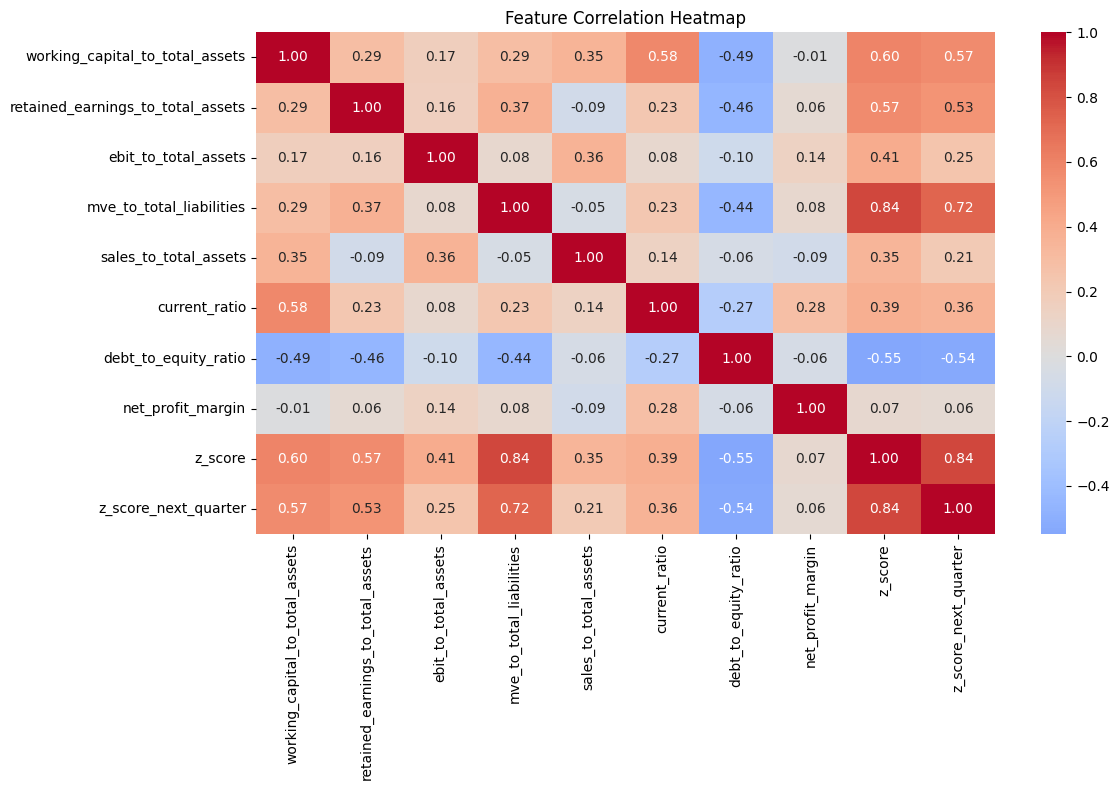

In [7]:
# Cell 6: Handle missing values and outliers

# Check for missing values in features and target
print("Missing values in features:")
print(X.isnull().sum())
print(f"\nMissing values in target: {y.isnull().sum()}")

# Remove rows with missing values (if any)
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

print(f"\n✅ After removing missing values:")
print(f"   Features Shape: {X.shape}")
print(f"   Target Shape: {y.shape}")

# Optional: Visualize correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = X.join(y).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [8]:
# Cell 7: Train/Test Split by Date Order (Temporal Split)

# Since we already sorted by date, we'll use a temporal split
# Using 80% for training and 20% for testing, maintaining chronological order

split_ratio = 0.8
split_index = int(len(X) * split_ratio)

# Split maintaining temporal order
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print("🔀 Train/Test Split (By Date Order - NOT Random)")
print("=" * 50)
print(f"   Training Set: {len(X_train)} samples ({split_ratio*100:.0f}%)")
print(f"   Testing Set:  {len(X_test)} samples ({(1-split_ratio)*100:.0f}%)")
print(f"\n   Training period: First {split_index} chronological observations")
print(f"   Testing period:  Last {len(X_test)} chronological observations")

🔀 Train/Test Split (By Date Order - NOT Random)
   Training Set: 1029 samples (80%)
   Testing Set:  258 samples (20%)

   Training period: First 1029 chronological observations
   Testing period:  Last 258 chronological observations


In [9]:
# Cell 8: Scale numerical features using RobustScaler
# RobustScaler is more robust to outliers than StandardScaler

scaler = RobustScaler()

# Fit on training data only, then transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)

print("✅ Feature Scaling Complete (RobustScaler)")
print(f"\n📊 Scaled Training Features - Sample Statistics:")
print(X_train_scaled.describe().round(4))

✅ Feature Scaling Complete (RobustScaler)

📊 Scaled Training Features - Sample Statistics:
       working_capital_to_total_assets  retained_earnings_to_total_assets  \
count                        1029.0000                          1029.0000   
mean                           -0.0226                             0.0418   
std                             0.8065                             0.8461   
min                            -2.3466                            -6.3673   
25%                            -0.4899                            -0.4513   
50%                             0.0000                             0.0000   
75%                             0.5101                             0.5487   
max                             2.7075                             2.1166   

       ebit_to_total_assets  mve_to_total_liabilities  sales_to_total_assets  \
count             1029.0000                 1029.0000              1029.0000   
mean                 0.2835                    0.3430  

In [10]:
# Cell 9: Define multiple regression models

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'SVR': SVR(kernel='rbf', C=1.0),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}

print(f"📋 Total Models to Train: {len(models)}")
print("\n📌 Models:")
for i, name in enumerate(models.keys(), 1):
    print(f"   {i}. {name}")

📋 Total Models to Train: 12

📌 Models:
   1. Linear Regression
   2. Ridge Regression
   3. Lasso Regression
   4. ElasticNet
   5. Decision Tree
   6. Random Forest
   7. Gradient Boosting
   8. AdaBoost
   9. XGBoost
   10. LightGBM
   11. SVR
   12. KNN


In [11]:
# Cell 10: Cross-Validation using TimeSeriesSplit

print("=" * 70)
print("CROSS-VALIDATION RESULTS (TimeSeriesSplit - 5 Folds)")
print("=" * 70)

# Use TimeSeriesSplit for time series data to respect temporal order
tscv = TimeSeriesSplit(n_splits=5)

cv_results = {}

for name, model in models.items():
    try:
        # Perform cross-validation with negative MSE (sklearn convention)
        cv_rmse = np.sqrt(-cross_val_score(model, X_train_scaled, y_train,
                                            cv=tscv, scoring='neg_mean_squared_error'))
        cv_mae = -cross_val_score(model, X_train_scaled, y_train,
                                   cv=tscv, scoring='neg_mean_absolute_error')
        cv_r2 = cross_val_score(model, X_train_scaled, y_train,
                                 cv=tscv, scoring='r2')

        cv_results[name] = {
            'CV_RMSE_Mean': cv_rmse.mean(),
            'CV_RMSE_Std': cv_rmse.std(),
            'CV_MAE_Mean': cv_mae.mean(),
            'CV_MAE_Std': cv_mae.std(),
            'CV_R2_Mean': cv_r2.mean(),
            'CV_R2_Std': cv_r2.std()
        }

        print(f"\n{name}:")
        print(f"   RMSE: {cv_rmse.mean():.4f} (+/- {cv_rmse.std():.4f})")
        print(f"   MAE:  {cv_mae.mean():.4f} (+/- {cv_mae.std():.4f})")
        print(f"   R²:   {cv_r2.mean():.4f} (+/- {cv_r2.std():.4f})")

    except Exception as e:
        print(f"\n{name}: Error - {str(e)}")

# Convert to DataFrame for visualization
cv_df = pd.DataFrame(cv_results).T
print("\n" + "=" * 70)
print("Cross-Validation Summary Table:")
print(cv_df.round(4))

CROSS-VALIDATION RESULTS (TimeSeriesSplit - 5 Folds)

Linear Regression:
   RMSE: 0.6970 (+/- 0.1844)
   MAE:  0.4293 (+/- 0.0434)
   R²:   0.5765 (+/- 0.2247)

Ridge Regression:
   RMSE: 0.6189 (+/- 0.0803)
   MAE:  0.4167 (+/- 0.0385)
   R²:   0.6822 (+/- 0.0541)

Lasso Regression:
   RMSE: 0.6421 (+/- 0.0694)
   MAE:  0.4526 (+/- 0.0418)
   R²:   0.6598 (+/- 0.0285)

ElasticNet:
   RMSE: 0.6247 (+/- 0.0687)
   MAE:  0.4311 (+/- 0.0375)
   R²:   0.6772 (+/- 0.0370)

Decision Tree:
   RMSE: 0.8571 (+/- 0.0616)
   MAE:  0.5758 (+/- 0.0382)
   R²:   0.3879 (+/- 0.0710)

Random Forest:
   RMSE: 0.6311 (+/- 0.0867)
   MAE:  0.4255 (+/- 0.0457)
   R²:   0.6713 (+/- 0.0461)

Gradient Boosting:
   RMSE: 0.6491 (+/- 0.0707)
   MAE:  0.4296 (+/- 0.0305)
   R²:   0.6517 (+/- 0.0365)

AdaBoost:
   RMSE: 0.6884 (+/- 0.0885)
   MAE:  0.5026 (+/- 0.0596)
   R²:   0.6085 (+/- 0.0528)

XGBoost:
   RMSE: 0.6845 (+/- 0.0768)
   MAE:  0.4591 (+/- 0.0371)
   R²:   0.6127 (+/- 0.0447)

LightGBM:
   RMSE: 

In [12]:
# Cell 11: Train all models and evaluate on test set

print("=" * 70)
print("MODEL TRAINING AND EVALUATION ON TEST SET")
print("=" * 70)

results = {}
trained_models = {}

for name, model in models.items():
    try:
        # Train the model
        model.fit(X_train_scaled, y_train)
        trained_models[name] = model

        # Predict on test set
        y_pred = model.predict(X_test_scaled)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results[name] = {
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        }

        print(f"\n{name}:")
        print(f"   RMSE: {rmse:.4f}")
        print(f"   MAE:  {mae:.4f}")
        print(f"   R²:   {r2:.4f}")

    except Exception as e:
        print(f"\n{name}: Error - {str(e)}")

# Convert results to DataFrame
results_df = pd.DataFrame(results).T.sort_values('R2', ascending=False)

print("\n" + "=" * 70)
print("MODEL COMPARISON TABLE (Sorted by R²):")
print("=" * 70)
print(results_df.round(4))

MODEL TRAINING AND EVALUATION ON TEST SET

Linear Regression:
   RMSE: 0.4853
   MAE:  0.3790
   R²:   0.8159

Ridge Regression:
   RMSE: 0.4858
   MAE:  0.3793
   R²:   0.8155

Lasso Regression:
   RMSE: 0.5712
   MAE:  0.4467
   R²:   0.7449

ElasticNet:
   RMSE: 0.5409
   MAE:  0.4157
   R²:   0.7713

Decision Tree:
   RMSE: 0.7915
   MAE:  0.5506
   R²:   0.5103

Random Forest:
   RMSE: 0.4758
   MAE:  0.3644
   R²:   0.8231

Gradient Boosting:
   RMSE: 0.4528
   MAE:  0.3460
   R²:   0.8398

AdaBoost:
   RMSE: 0.5222
   MAE:  0.4319
   R²:   0.7869

XGBoost:
   RMSE: 0.5235
   MAE:  0.3910
   R²:   0.7858

LightGBM:
   RMSE: 0.4760
   MAE:  0.3702
   R²:   0.8229

SVR:
   RMSE: 0.4203
   MAE:  0.3234
   R²:   0.8619

KNN:
   RMSE: 0.6314
   MAE:  0.4754
   R²:   0.6884

MODEL COMPARISON TABLE (Sorted by R²):
                     RMSE     MAE      R2
SVR                0.4203  0.3234  0.8619
Gradient Boosting  0.4528  0.3460  0.8398
Random Forest      0.4758  0.3644  0.8231
LightGB

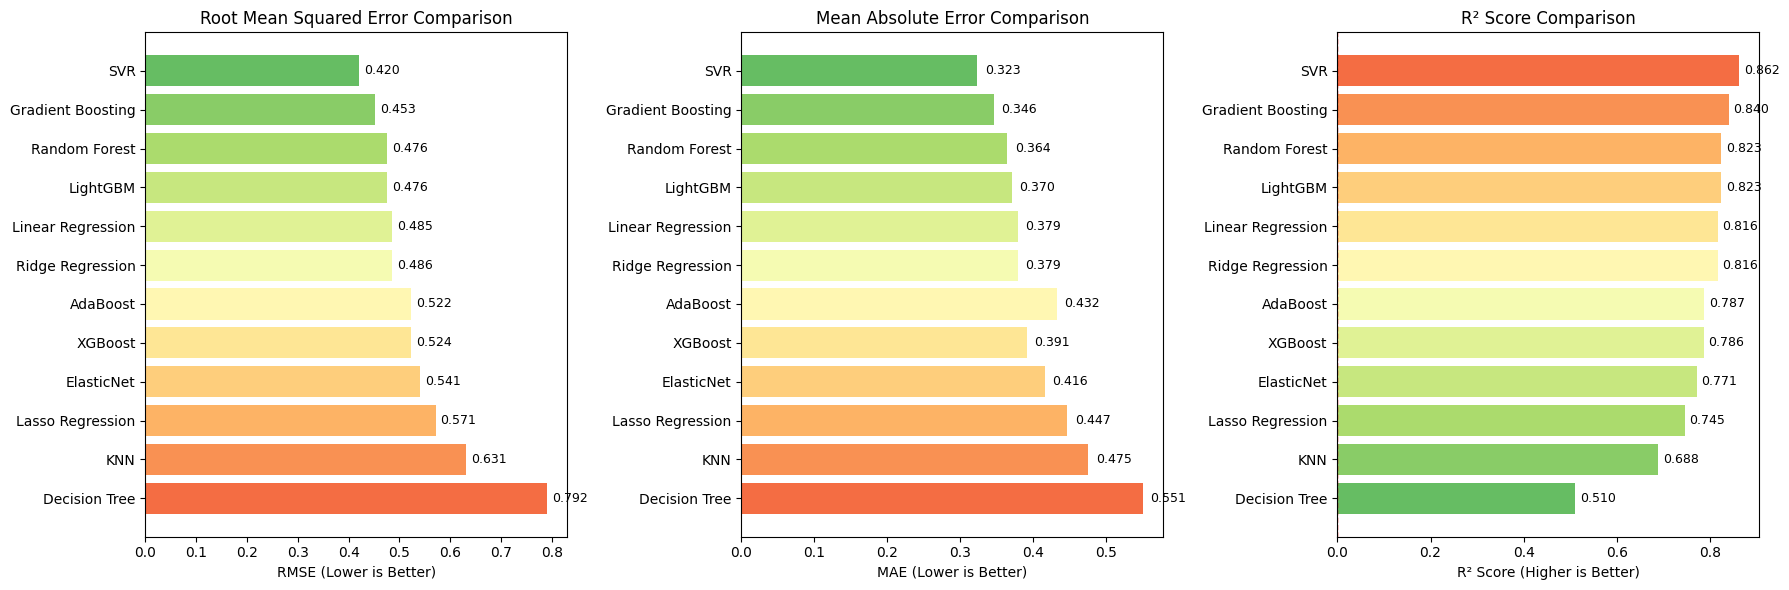

📊 Model comparison chart saved as 'model_comparison.png'


In [13]:
# Cell 12: Visualize model comparison

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: RMSE Comparison
ax1 = axes[0]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(results_df)))
bars1 = ax1.barh(results_df.index, results_df['RMSE'], color=colors)
ax1.set_xlabel('RMSE (Lower is Better)')
ax1.set_title('Root Mean Squared Error Comparison')
ax1.invert_yaxis()
for bar, val in zip(bars1, results_df['RMSE']):
    ax1.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

# Plot 2: MAE Comparison
ax2 = axes[1]
bars2 = ax2.barh(results_df.index, results_df['MAE'], color=colors)
ax2.set_xlabel('MAE (Lower is Better)')
ax2.set_title('Mean Absolute Error Comparison')
ax2.invert_yaxis()
for bar, val in zip(bars2, results_df['MAE']):
    ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

# Plot 3: R² Comparison
ax3 = axes[2]
colors_r2 = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(results_df)))
bars3 = ax3.barh(results_df.index, results_df['R2'], color=colors_r2)
ax3.set_xlabel('R² Score (Higher is Better)')
ax3.set_title('R² Score Comparison')
ax3.invert_yaxis()
ax3.axvline(x=0, color='red', linestyle='--', linewidth=1)
for bar, val in zip(bars3, results_df['R2']):
    ax3.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Model comparison chart saved as 'model_comparison.png'")

In [14]:
# Cell 13: Automatically select the best model

print("=" * 70)
print("🏆 BEST MODEL SELECTION")
print("=" * 70)

# Find the best model based on R² score
best_model_name = results_df['R2'].idxmax()
best_model = trained_models[best_model_name]
best_metrics = results[best_model_name]

print(f"\n🥇 Best Model: {best_model_name}")
print(f"\n📊 Performance Metrics:")
print(f"   • RMSE: {best_metrics['RMSE']:.4f}")
print(f"   • MAE:  {best_metrics['MAE']:.4f}")
print(f"   • R²:   {best_metrics['R2']:.4f}")

# Also show runner-ups
print(f"\n🥈 Runner-up Models (by R²):")
for i, (name, row) in enumerate(results_df.iloc[1:4].iterrows(), 2):
    print(f"   {i}. {name}: R² = {row['R2']:.4f}")

🏆 BEST MODEL SELECTION

🥇 Best Model: SVR

📊 Performance Metrics:
   • RMSE: 0.4203
   • MAE:  0.3234
   • R²:   0.8619

🥈 Runner-up Models (by R²):
   2. Gradient Boosting: R² = 0.8398
   3. Random Forest: R² = 0.8231
   4. LightGBM: R² = 0.8229


FEATURE IMPORTANCE ANALYSIS


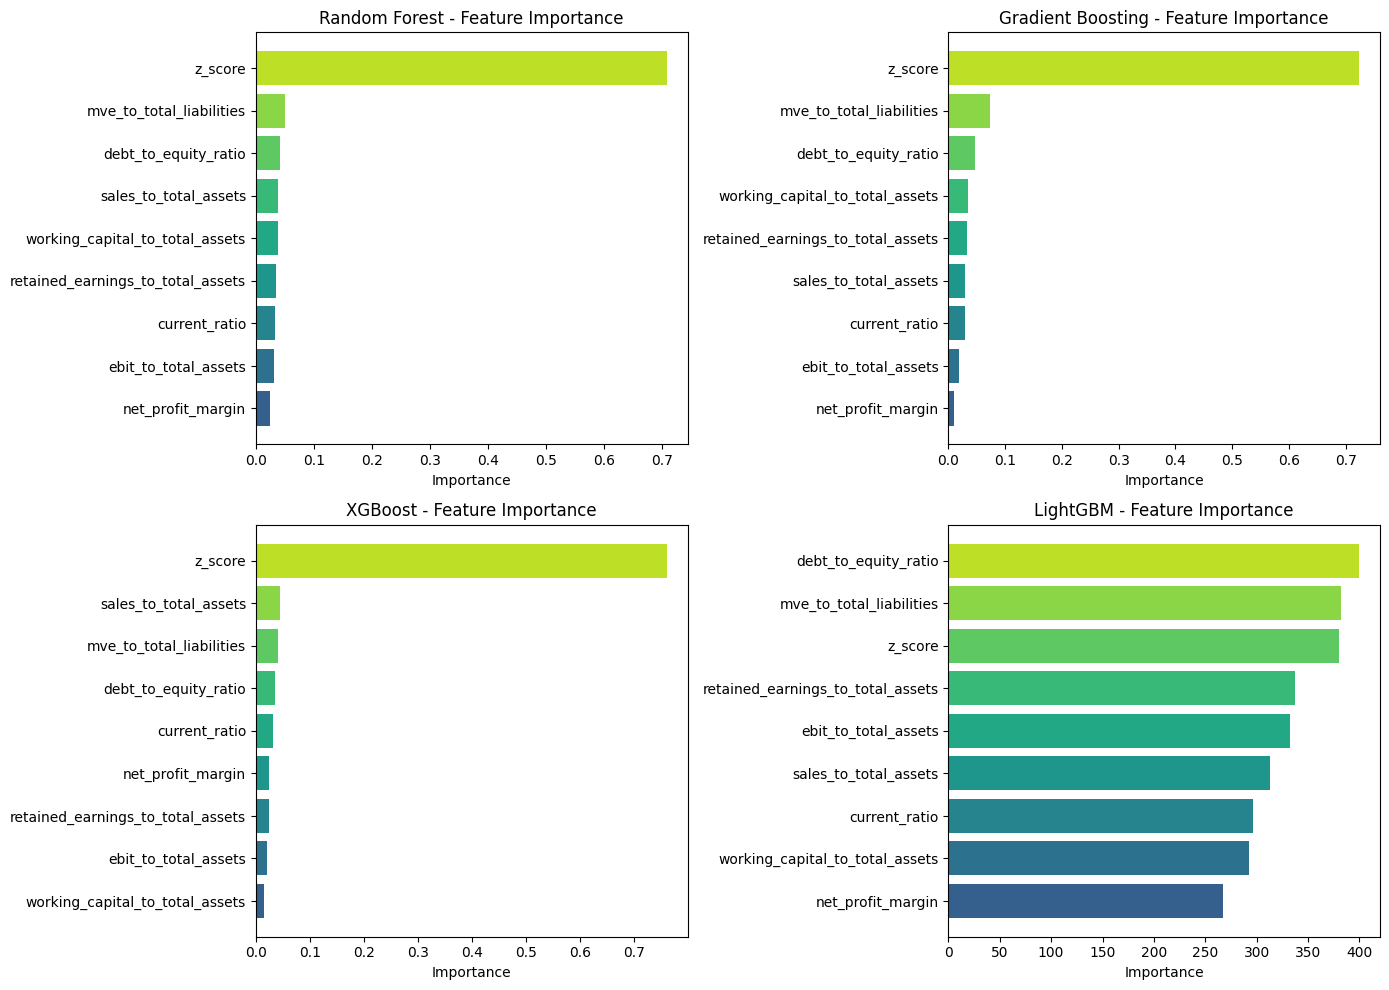

📊 Feature importance chart saved as 'feature_importance.png'


In [15]:
# Cell 14: Feature Importance Analysis

print("=" * 70)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

# Get feature importance from tree-based models
feature_importance_models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, model_name in enumerate(feature_importance_models):
    if model_name in trained_models:
        model = trained_models[model_name]
        importance = model.feature_importances_

        # Create importance DataFrame
        importance_df = pd.DataFrame({
            'Feature': feature_columns,
            'Importance': importance
        }).sort_values('Importance', ascending=True)

        # Plot
        ax = axes[idx]
        colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(importance_df)))
        ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
        ax.set_xlabel('Importance')
        ax.set_title(f'{model_name} - Feature Importance')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Feature importance chart saved as 'feature_importance.png'")

ACTUAL vs PREDICTED: SVR


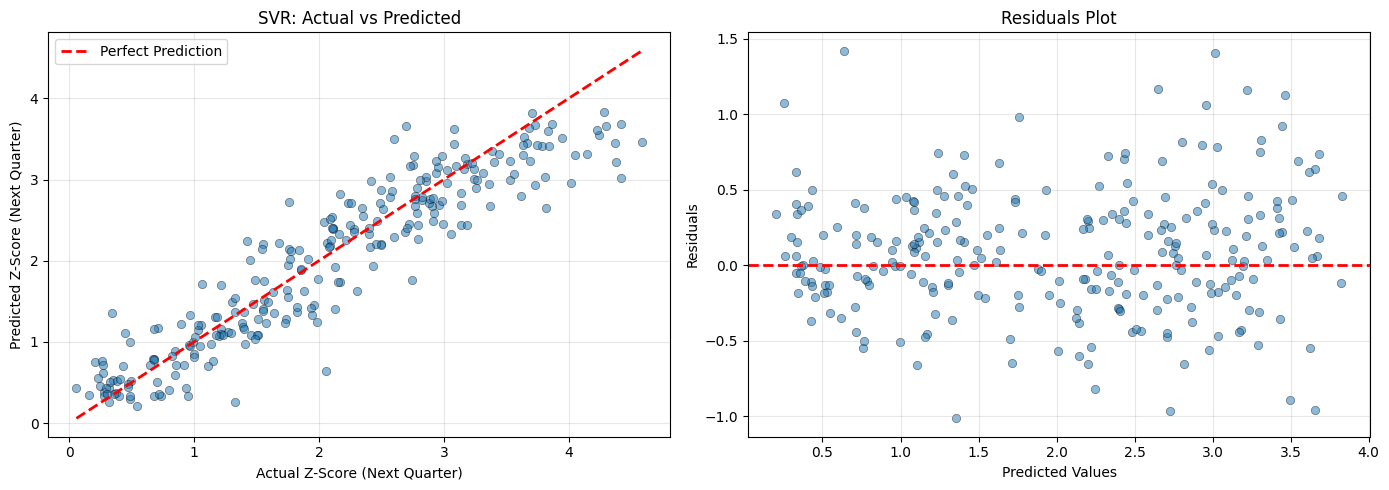


📊 Residual Statistics:
   Mean Residual: 0.0842
   Std Residual:  0.4126
   Min Residual:  -1.0135
   Max Residual:  1.4198


In [16]:
# Cell 15: Actual vs Predicted Visualization for Best Model

print("=" * 70)
print(f"ACTUAL vs PREDICTED: {best_model_name}")
print("=" * 70)

# Get predictions from best model
y_pred_best = best_model.predict(X_test_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scatter plot of Actual vs Predicted
ax1 = axes[0]
ax1.scatter(y_test, y_pred_best, alpha=0.5, edgecolors='black', linewidth=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Z-Score (Next Quarter)')
ax1.set_ylabel('Predicted Z-Score (Next Quarter)')
ax1.set_title(f'{best_model_name}: Actual vs Predicted')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals plot
residuals = y_test - y_pred_best
ax2 = axes[1]
ax2.scatter(y_pred_best, residuals, alpha=0.5, edgecolors='black', linewidth=0.5)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals Plot')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

# Residual statistics
print(f"\n📊 Residual Statistics:")
print(f"   Mean Residual: {residuals.mean():.4f}")
print(f"   Std Residual:  {residuals.std():.4f}")
print(f"   Min Residual:  {residuals.min():.4f}")
print(f"   Max Residual:  {residuals.max():.4f}")

In [17]:
# Cell 16: Save the best model and scaler

import joblib

# Save the best model
model_filename = f'best_model_{best_model_name.replace(" ", "_").lower()}.joblib'
joblib.dump(best_model, model_filename)
print(f"✅ Best model saved as: {model_filename}")

# Save the scaler
scaler_filename = 'feature_scaler.joblib'
joblib.dump(scaler, scaler_filename)
print(f"✅ Scaler saved as: {scaler_filename}")

# Download files
from google.colab import files
files.download(model_filename)
files.download(scaler_filename)

print("\n📦 Files ready for download!")

✅ Best model saved as: best_model_svr.joblib
✅ Scaler saved as: feature_scaler.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📦 Files ready for download!


In [18]:
# Cell 17: Final Summary Report

print("=" * 70)
print("📝 FINAL SUMMARY REPORT")
print("=" * 70)

print(f"""
Dataset Information:
--------------------
- Total Samples: {len(df)}
- Training Samples: {len(X_train)}
- Testing Samples: {len(X_test)}
- Number of Features: {len(feature_columns)}

Features Used:
--------------
{chr(10).join([f'  • {col}' for col in feature_columns])}

Target Variable:
----------------
- z_score_next_quarter

Best Model Selected:
--------------------
- Model: {best_model_name}
- Test RMSE: {best_metrics['RMSE']:.4f}
- Test MAE: {best_metrics['MAE']:.4f}
- Test R²: {best_metrics['R2']:.4f}

Model Performance Ranking (by R²):
----------------------------------
""")

for i, (name, row) in enumerate(results_df.iterrows(), 1):
    print(f"  {i:2d}. {name:25s} | R² = {row['R2']:.4f} | RMSE = {row['RMSE']:.4f} | MAE = {row['MAE']:.4f}")

print("\n" + "=" * 70)
print("🎉 MODEL TRAINING COMPLETE!")
print("=" * 70)

📝 FINAL SUMMARY REPORT

Dataset Information:
--------------------
- Total Samples: 1287
- Training Samples: 1029
- Testing Samples: 258
- Number of Features: 9

Features Used:
--------------
  • working_capital_to_total_assets
  • retained_earnings_to_total_assets
  • ebit_to_total_assets
  • mve_to_total_liabilities
  • sales_to_total_assets
  • current_ratio
  • debt_to_equity_ratio
  • net_profit_margin
  • z_score

Target Variable:
----------------
- z_score_next_quarter

Best Model Selected:
--------------------
- Model: SVR
- Test RMSE: 0.4203
- Test MAE: 0.3234
- Test R²: 0.8619

Model Performance Ranking (by R²):
----------------------------------

   1. SVR                       | R² = 0.8619 | RMSE = 0.4203 | MAE = 0.3234
   2. Gradient Boosting         | R² = 0.8398 | RMSE = 0.4528 | MAE = 0.3460
   3. Random Forest             | R² = 0.8231 | RMSE = 0.4758 | MAE = 0.3644
   4. LightGBM                  | R² = 0.8229 | RMSE = 0.4760 | MAE = 0.3702
   5. Linear Regression    